<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/Stock_Price_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of Amazon Stock Price Direction

The stock prices are constantly changing and difficult to predict with certainty. Instead of trying to pinpoint the exact future price, a more practical approach for making profits is to predict the direction of the price movement: will it go up or down?

If we anticipate a price increase, we would consider buying stock, while a predicted price decrease would suggest selling.

Therefore, our goal is to create a system that classifies each day into one of two categories:

1. **Price Increase**: The closing price tomorrow will be higher than the opening price.
2. **Price Decrease**: The closing price tomorrow will be lower than the opening price."

We have data for the period from `1997` up to the year `2020` that are already split into training (`1997-2016`), validation (`2016-2018`) and testing (`2018-2020`) periods. The data is available in the `AMZN_train.csv`, `AMZN_val.csv` and `AMZN_test.csv` files, respectively.

**Benefits of Splitting for the Amazon Stock Data:**

* **Realistic Performance Evaluation:** By testing on data the model has never seen before (`2018-2020`), we get a realistic idea of how it will perform in the future. This is essential for making informed trading decisions.
* **Avoiding Overfitting:** The validation set (`2016-2018`) helps prevent overfitting, ensuring the model learns underlying patterns in stock price movements rather than just memorizing the training data.
* **Model Selection:** We can train multiple models with different parameters and compare their performance on the validation set. This allows us to choose the best-performing model for the task.
* **Increased Confidence:** A model that performs well on both the validation and test sets provides higher confidence that it will generalize to new data and be useful for making predictions about future stock price movements.

##Data Exploration
In our initial exploration, we will load the data sets and see what data attributes are available to us. We will also plot the variables, to see if we can find some trends in the data, and explore the possibility of engineering some additional features. We will do the data loading and analysis in pandas, so let us load that library and begin exploring.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from warnings import filterwarnings

# Ignore warnings
filterwarnings('ignore')

In [ ]:
# load the training set
from google.colab import drive
drive.mount('/content/drive')
# Load data
AMZ_train_path = '/content/drive/MyDrive/Colab Notebooks/Stock Price Direction/AMZN_train.csv'
# Read the AMZN_train.csv
df_train = pd.read_csv(AMZ_train_path)

Mounted at /content/drive


In [ ]:
# (#rows, #columns)
df_train.shape

(4781, 7)

Pandas' `info()` method is really useful to get a quick peek at the column names, types, non-null counts, as well as the data set's memory size! We have mostly numerical columns (5 floats, 1 int) and an object column - the date. No null values at all, and just 261 KB in size.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB


The training data set consists of `4781` rows and `7` columns. These are presented above. In the cell below, we use the `describe()` method to get a quick overview of our data set. By default, this includes only numerical columns, since the summary statistics are different for attributes of different types (for example, the date, or other categorical attributes). For numerical columns, this method outputs the non-null count, the mean, standard deviation, the minimum and maximum value, and the 25th, 50th and 75th percentile value.

In [ ]:
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,127.619845,129.480122,125.697925,127.662449,127.662449,8.225935e+06
std,145.693083,147.132537,144.053633,145.677581,145.677581,7.810188e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,34.299999,34.849998,33.660000,34.310001,34.310001,4.200900e+06
50%,62.880001,64.750000,60.937500,62.750000,62.750000,6.200100e+06
75%,189.009995,191.600006,186.210007,189.029999,189.029999,9.239900e+06
max,717.380005,722.450012,711.510010,717.929993,717.929993,1.043292e+08


If we try to run the same method on the `Date` column (which is treated as an object) we get the following output: a count of non-null values, a count of unique values, the top (or max) value and its corresponding frequency. While this does give us some information, such that there is exactly one row for each day, and that there are no days with a missing date, it is missing the time range for the column, so what we can do, is try to run `min()` and`max()` to get the first and last date for the data set. These are `1997-05-15` and `2016-05-13`, respectively.

In [ ]:
df_train["Date"].describe()

,Date
count,4781
unique,4781
top,1997-05-15
freq,1


In [ ]:
df_train["Date"].min(), df_train["Date"].max()

('1997-05-15', '2016-05-13')

One last thing we can try in the initial analysis of the data is to plot the stock prices as a function of time. These plots are the first thing we see on any stock market. We can use the pandas' `plot(...)` method to plot lines, bypassing the `Date` column as an argument for the `x` axis, and the closing, opening, highest and lowest price to be plotted on the `y` axis. For readability, we also set the figure size to `(12, 9)`.

In [ ]:
# dictionary-like object that stores the default settings for matplotlib plots
plt.rcParams["figure.figsize"] = (12, 9)

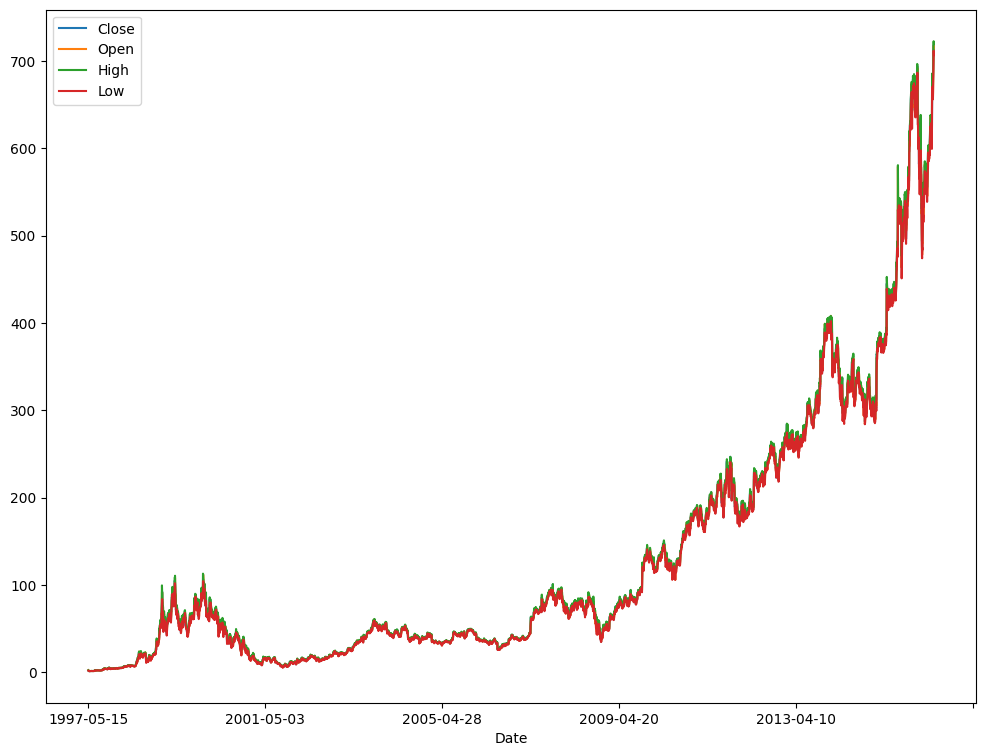

In [ ]:
df_train.plot(x="Date", y=["Close", "Open", "High", "Low"])
plt.show()

All prices are very close to each other since the lines are overlapping nearly everywhere. But, the price has grown significantly over the years, starting at around `$100` at the beginning of the century, rising to almost `$700` only 13 years later!

We would like to repeat the same analysis for the validation and testing set, to make sure that they follow a similar distribution and that there are no surprising errors there. It makes sense to create a function to repeat the process we did for the training set, instead of repeat the codes.

In [ ]:
def analyse(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("Shape", dataframe.shape, "\n")
    print("Columns", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")
    print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
    dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])


Shape (503, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB

               Open         High          Low        Close    Adj Close  \
count   503.000000   503.000000   503.000000   503.000000   503.000000   
mean    992.201292   999.898131   982.574513   991.828966   991.828966   
std     255.496588   259.220381   250.100614   254.885469   254.885469   
min     689.559998   696.820007   682.119995   691.359985   6

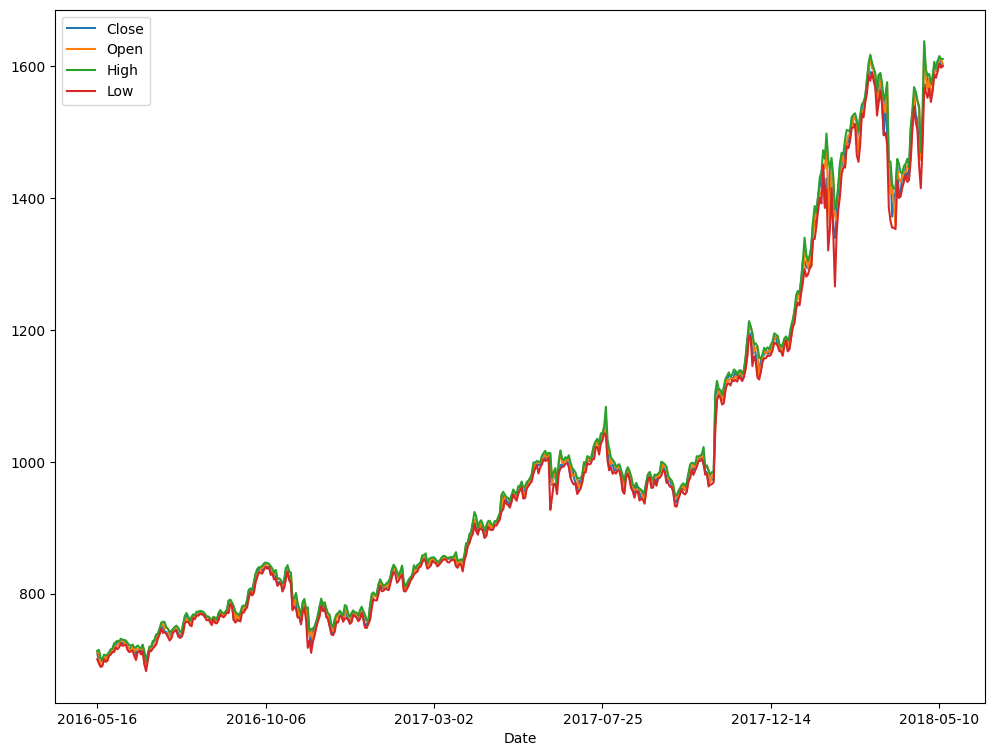

In [ ]:
# Load data
AMZ_val_path = '/content/drive/MyDrive/Colab Notebooks/Stock Price Direction/AMZN_val.csv'
# Read the AMZN_train.csv
df_val = pd.read_csv(AMZ_val_path)

# read validation and test sets and then analyse them
analyse(df_val)

The validation set has the same properties as the training set: no null values, clear column types, and a valid date range. The stocks have continued to grow in this period.

Shape (504, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB

               Open         High          Low        Close    Adj Close  \
count   504.000000   504.000000   504.000000   504.000000   504.000000   
mean   1823.927758  1843.069246  1803.067065  1824.040536  1824.040536   
std     178.129809   179.294163   177.457741   178.470078   178.470078   
min    1346.000000  1396.030029  1307.000000  1343.959961  13

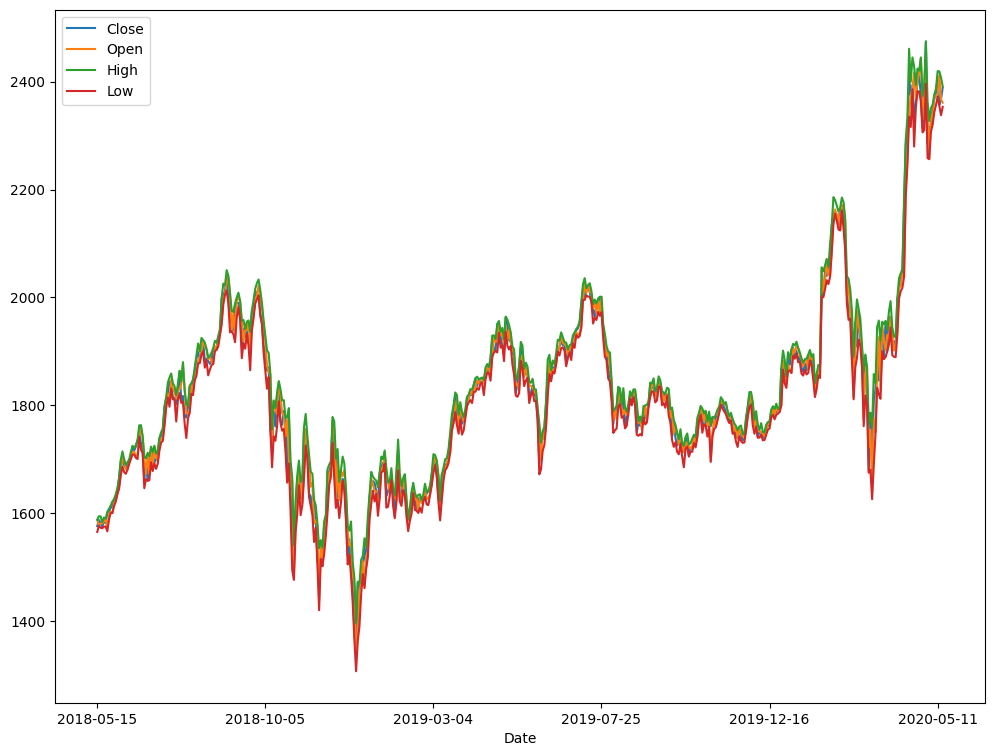

In [ ]:
# Load data
AMZ_val_path = '/content/drive/MyDrive/Colab Notebooks/Stock Price Direction/AMZN_test.csv'
# Read the AMZN_test.csv
df_test = pd.read_csv(AMZ_val_path)

analyse(df_test)

Similar observations from the validation set also apply to the test set, with continued stock growth but increased volatility.

Having explored the data, we proceed to predictive modeling. Our goal is to predict whether the next day's closing price will exceed the opening price. As this information isn't directly available, we'll derive it.

This involves comparing the closing and opening prices one day in advance. To ensure accurate comparisons, we'll first sort the data by date using the `sort_values` method.

Next, we'll utilize the Pandas `shift` method with a period of -1 to bring the next day's closing price to the current day's row. This comparison will result in `True/False` values, which we'll convert to `1/0` for machine learning model compatibility. These values will be stored in a new column named `Target`.

In [ ]:
# sorting our data by date
df_train.sort_values(by="Date", inplace=True)
df_val.sort_values(by="Date", inplace=True)
df_test.sort_values(by="Date", inplace=True)

In [ ]:
# shifting by a period of '-1', this takes the next day's price direction for the current day
# a positive period will take the days from the past
df_train["Target"] = (df_train["Close"] > df_train["Open"]).shift(periods=-1, fill_value=0).astype(int)

Running the value_counts method on the `Target` column gives us the distribution. We have `2292` days where the closing price is higher than the opening and `2389` where it is lower.

In [ ]:
df_train["Target"].value_counts()

,count
Target,
1,2392
0,2389


We are going to repeat the same procedure for the validation and test set as well.

In [ ]:
df_val["Target"] = (df_val["Close"] > df_val["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_val["Target"].value_counts()

,count
Target,
0,255
1,248


In [ ]:
df_test["Target"] = (df_test["Close"] > df_test["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_test["Target"].value_counts()

,count
Target,
1,255
0,249


Before building machine learning models to predict the target, let's engineer additional features that may enhance predictive power.

##Feature Engineering

Stock prices are time-dependent, meaning the next day's price is influenced by previous days' prices (and other factors).

To capture trends and price change magnitude, we need to consider values from the past `n` days. A simple solution is calculating a moving average, which computes the arithmetic mean within a sliding window. For each day `X`, the moving average of order `n` is the arithmetic mean of prices from days `X - 1`, `X - 2`, ..., `X - n`.

Pandas provides the `rolling()` method for these sliding window calculations. We'll use it to calculate 3- and 7-day moving averages, adding them as features to the dataset.

When predicting price direction, it's crucial to consider recent price behavior, not just today's price. The moving average provides a summary of this recent price action.

We need to ensure the data is sorted by date, as unsorted data will produce invalid results from the `rolling()` method.

In [ ]:
# 3-day moving average of the daily price change
df_train["Moving_Average_3"] = (df_train["Close"] - df_train["Open"]).rolling(window=3, min_periods=1).mean()
df_val["Moving_Average_3"] = (df_val["Close"] - df_val["Open"]).rolling(window=3, min_periods=1).mean()
df_test["Moving_Average_3"] = (df_test["Close"] - df_test["Open"]).rolling(window=3, min_periods=1).mean()

In [ ]:
# 7-day moving average of the daily price change
df_train["Moving_Average_7"] = (df_train["Close"] - df_train["Open"]).rolling(window=7, min_periods=1).mean()
df_val["Moving_Average_7"] = (df_val["Close"] - df_val["Open"]).rolling(window=7, min_periods=1).mean()
df_test["Moving_Average_7"] = (df_test["Close"] - df_test["Open"]).rolling(window=7, min_periods=1).mean()

Today's Direction feature represents the current day's price change (Close - Open).

In [ ]:
# current price direction
# we should repeat the procedure for all three sets (train, val, test)
df_train["Today_Direction"] = df_train["Close"] - df_train["Open"]
df_val["Today_Direction"] = df_val["Close"] - df_val["Open"]
df_test["Today_Direction"] = df_test["Close"] - df_test["Open"]

Price Range calculates the daily price range (High - Low) as a measure of volatility

In [ ]:
# price range
df_train["Price_Range"] = df_train["High"] - df_train["Low"]
df_val["Price_Range"] = df_val["High"] - df_val["Low"]
df_test["Price_Range"] = df_test["High"] - df_test["Low"]

The next cell displays a sample of the data with the new features included.

In [ ]:
df_train.sample(10, random_state=42)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_7,Today_Direction,Price_Range
2895,2008-11-14,43.610001,44.500000,41.500000,41.750000,41.750000,11949700,0,-0.253335,-0.601429,-1.860001,3.000000
4430,2014-12-22,301.940002,307.359985,301.940002,306.540009,306.540009,4003800,0,0.436666,-0.705710,4.600007,5.419983
3618,2011-09-29,234.169998,234.300003,216.289993,222.440002,222.440002,9378500,0,-6.126663,-2.434283,-11.729996,18.010010
763,2000-05-24,46.437500,49.750000,40.437500,48.562500,48.562500,11666600,0,-0.937500,-0.580357,2.125000,9.312500
4392,2014-10-28,289.760010,298.000000,289.760010,295.589996,295.589996,5572600,0,4.253326,2.681423,5.829986,8.239990
4657,2015-11-16,640.919983,649.989990,622.289978,647.809998,647.809998,7435900,0,-7.243347,-0.264299,6.890015,27.700012
4008,2013-04-22,259.350006,264.600006,258.029999,263.549988,263.549988,2119100,1,-0.343333,-0.287140,4.199982,6.570007
555,1999-07-29,51.187500,52.187500,50.000000,50.781250,50.781250,18748000,0,-0.841146,-0.713170,-0.406250,2.187500
2754,2008-04-28,80.639999,82.500000,80.120003,81.970001,81.970001,10991900,0,1.453336,1.212857,1.330002,2.379997
33,1997-07-02,1.515625,1.593750,1.510417,1.588542,1.588542,3882000,1,0.026042,0.004464,0.072917,0.083333


##Classical ML Algorithms

We can try to implement and test some of the classical ML algorithms:

1.   Logistic regression
2.   Decision tree
1.   Random forest
2.   Gradient boosting ensemble

All of these algorithms are implemented in the `sklearn.linear_model` module. All of them share also the same interface, i.e., we can use the same procedure for implementing any of them.

After fitting them to the training data, we are going to evaluate their performance on the validation set by estimating the AUC metric.

For easier manipulation, we will specify the target column and the feature (input) columns as lists, which we will then use to project the corresponding data frame.




In [ ]:
# this is the target column that we aim to predict
y_col = "Target"
# these are the input features for the models
X_cols = [
    "Open",
    "Close",
    "High",
    "Low",
    "Volume",
    "Adj Close",
    "Today_Direction",
    "Price_Range",
    "Moving_Average_3",
    "Moving_Average_7"
]

In [ ]:
X_train = df_train[X_cols]
y_train = df_train[y_col]

X_val = df_val[X_cols]
y_val = df_val[y_col]

X_test = df_val[X_cols]
y_test = df_val[y_col]

###Logistic Regression
We begin with a LogisticRegression model. This algorithm is similar to linear regression but uses a sigmoid function to adapt its output for classification tasks.

We utilize the `RocCurveDisplay(...)` method to calculate the AUC value and plot the ROC curve, using the fitted model and validation set.

For this and subsequent algorithms, we will use the default model parameters.

In [ ]:
# for reproducibility
RANDOM_SEED = 42

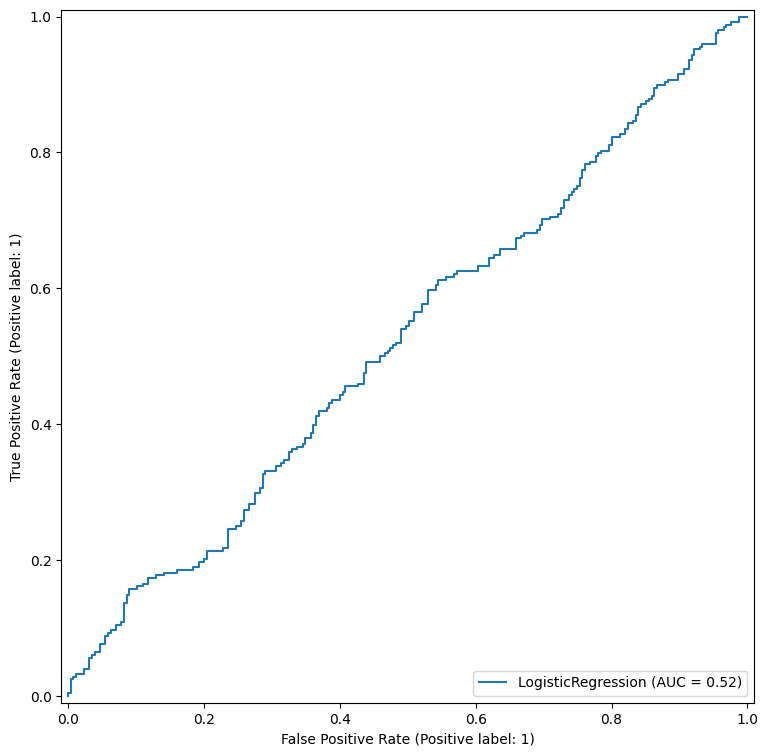

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

# use default parameters
lr = LogisticRegression()

# fit to train set
lr.fit(X_train, y_train)

# plot RocCurve, and show AUC for the validation set
RocCurveDisplay.from_estimator(lr, X_val, y_val)

Logistic regression works well for this problem. Given that we are dealing with a very difficult problem having `AUC > 0.5` means that the classifier would suffice for this task.

###Decision Tree

Next, we'll explore a decision tree. Decision trees are better suited for non-linear data, potentially outperforming logistic regression.

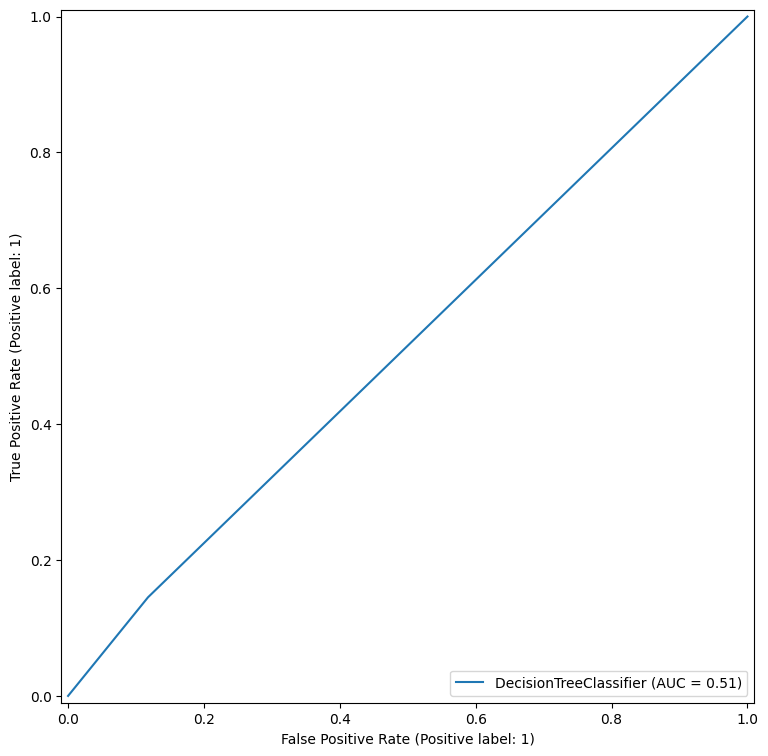

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# remember to use the random seed to be able to reproduce the same results
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt.fit(X_train, y_train)

RocCurveDisplay.from_estimator(dt, X_val, y_val)

The decision tree underperforms the logistic regression model by `0.01`, and its AUC is above 0.5!

###Random Forest
Now we will try to use many decision trees, i.e., a forest. Random forest is an ensemble model that builds multiple decision trees, each with a different (random) sub-set of attributes. It is generally expected that an ensemble model would outperform a base learner (i.e., the combination of predictions from many decision trees would be better / more stable than the prediction of just one decision tree).

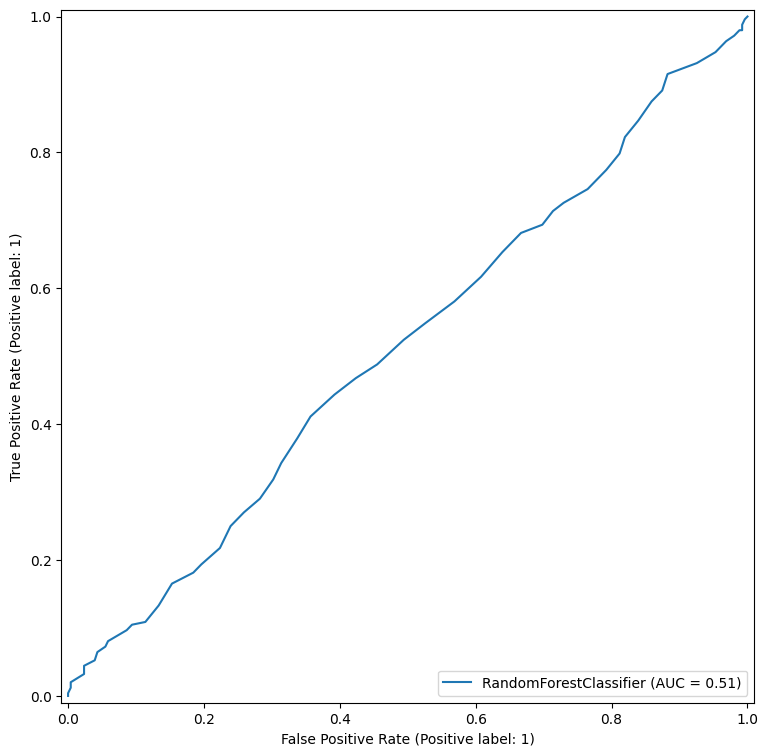

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(rf, X_val, y_val)

The model does not outperform the decision tree, it actually performs the same.

###Gradient Boosting Ensemble
One last ensemble technique that we would like to try is gradient boosting. This algorithm sets up the stage for our next part, where we will try a deep learning approach to solve the problem. A gradient boosting classifier is structurally the same as any ensemble learner - it is a collection of base learners (think of these as decision trees for simplicity, in theory, they can be anything). The algorithm induces (learns) the trees one by one, and in each iteration, it gives greater weight to those instances that were wrongly misclassified, so the next tree would "pay more attention" while training on them. Sometimes this can improve performance.

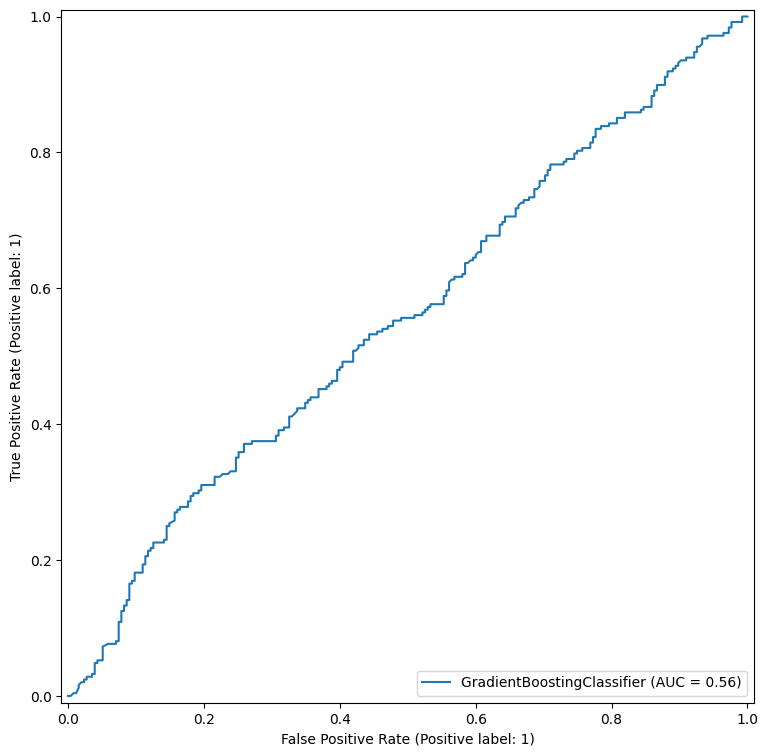

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
gb.fit(X_train, y_train)

RocCurveDisplay.from_estimator(gb, X_val, y_val)

We find out that gradient boosting works best for this data set. It outperformed previous models and scored `0.56 AUC`!

Let's train a deep learning model and try to outperform the baseline set here, i.e., `AUC = 0.56`.

###Deep Learning Algorithm
We are going to use Google's open-source library Tensorflow for implementing a small neural network. We are using version `2.17.1` of Tensorflow.

In [ ]:
import tensorflow as tf
import numpy as np
import random
# set seed for reproducibility of results
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

tf.config.experimental.enable_op_determinism()

print("Tensorflow version", tf.__version__)

Tensorflow version 2.17.1


Keras is the most popular framework for designing deep learning models. In the next cell, we implement a sequential neural network with:

1. Normalization layer that scales the data to a common range
2. A dense layer with 10 neurons and a ReLU activation function.
3. A dropout layer (regularization technique) with a 0.2 probability of dropping a neuron.
4. Another dense layer with 5 neurons and ReLU activation function.
5. An output layer of just one neuron with a sigmoid activation function (the same one mentioned in the logistic regression part above)

We can change, add or remove any of the layers and try to design a better-performing model. Given that our data is relatively small, both in terms of training instances as well as in the number of columns, it is recommended that the model is small, otherwise, it will overfit very quickly.

In summary, this code defines a simple `Feedforward Neural Network` with two hidden layers (10 and 5 neurons respectively), dropout for regularization, and a sigmoid output for binary classification (predicting price increase or decrease). The input layer is configured to match the number of features in your training data.

In [ ]:
# defines the input layer
input_layer = tf.keras.Input(shape=(X_train.shape[1],)) # 1 is number of features in out training data, defined earlier

# creates a sequential model, which is a linear stack of layers, the simpliest way to build NN in Keras
model = tf.keras.models.Sequential([
    input_layer,
    # normalizes the input data, it helps the model train more efficiently by scaling the data to a standard range
    tf.keras.layers.Normalization(axis=-1),
    # dense layer applies a weighted sum of the inputs and passes the result through a ReLU
    tf.keras.layers.Dense(units=10, activation="relu",kernel_initializer='random_normal',bias_initializer='zeros'),
    # it randomly drops out (sets to 0) 20% of the neurons during training to prevent overfitting
    tf.keras.layers.Dropout(rate=0.2, seed=RANDOM_SEED),
    # `random_normal` initializes weights with random values drawn from a normal distribution, while `zeros` initializes biases to 0.
    tf.keras.layers.Dense(units=5, activation="relu",kernel_initializer='random_normal',bias_initializer='zeros'),
    # produces an output between 0 and 1, the probability of the stock price going up (1) or down (0)
    tf.keras.layers.Dense(units=1, activation="sigmoid", kernel_initializer='random_normal',bias_initializer='zeros')
])

In [ ]:
# this configures the model's loss function, weight optimizer, and metrics to keep track of
model.compile(
    loss="binary_crossentropy", # Keras automatically creates an entry in the history.history dictionary with the key 'loss'
    optimizer=tf.keras.optimizers.Adam(), # algorithm responsible for updating the model's weights during training to minimize the loss function
    metrics=['AUC']
)

We used the sigmoid activation function in our output layer to produce a probability of the stock price going up or down, which is essential for cross-entropy to calculate the loss function to measure the error between the predicted probabilities and the actual target values.

We are going to train our model for `50` epochs, and keep track of its loss (binary_crossentropy) and AUC values during each epoch.

To prevent overfitting, we are implementing two callbacks (functions to be called after each epoch):

1. Learning rate scheduler that decays the learning rate as the number of epochs increases.
2. Early stopping callback that stops training if the loss does not improve after a certain number of epochs.

In [ ]:
def learning_rate_scheduler(epoch, learning_rate):
    """
    This function is designed to adjust the learning rate of the optimizer during training.
    The learning rate determines how much the model's weights are adjusted with each update.
    """
    if epoch < 5: #  function's logic is to keep the learning rate constant for the first 5 epochs
        return learning_rate
    else:
        # gradual reduction in learning rate helps the model fine-tune its weights and converge to a better solution
        return learning_rate * float(tf.math.exp(-0.01).numpy()) # after 5 epochs, it starts decaying the learning rate exponentially

# training will stop if the model's performance on the validation set doesn't improve for 10 consecutive epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
# restore_best_weights=True: ensures that the model's weights are reverted to the best-performing state (based on the validation set) before early stopping occurred.
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
# the learning rate will be adjusted according to the logic defined in

In [ ]:
# the model.fit(...) method returns a 'history' object with stats about the training
history = model.fit(
    x=X_train,
    y=y_train,
    # separate dataset that the model will be evaluated on during training
    # this helps monitor the model's performance on unseen data and prevents overfitting
    validation_data=(X_val, y_val),
    # an epoch is one complete pass through the entire training dataset, in this case 50
    epochs=50,
    # controls the amount of information displayed, showing the loss and metrics after each epoch
    verbose=1,
    # early_stopping_callback - stops training if the model's performance on the validation data doesn't improve for a certain number of epochs
    callbacks=[early_stopping_callback, learning_rate_callback],
    shuffle=False
)   # learning_rate_callback - adjusts the learning rate (how quickly the model learns) during training & helps the model fine-tune its predictions

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.4979 - loss: 96.9884 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.4881 - loss: 1.3183 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.4905 - loss: 1.7560 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5133 - loss: 0.9566 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.4934 - loss: 0.9462 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5033 - loss: 0.8699 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 9.9005e-04
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4992 - loss: 0.7553 - val_AUC: 0.5000 - val_loss: 0.6931 - learning_rate: 9.8020e-

In [ ]:
ve

We let the model train for `50` epochs. We can see the change in the learning rate, which is due to the learning rate scheduler callback that we have implemented. The early stopping callback fired at the 11th epoch, which means that the validation loss has not been improving over time. Even the AUC for training and the validation are not improving the overall score and are very close to `0.5`.

We have an overview of the structure of the model.

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization)      │ (None, 10)                  │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 536 (2.10 KB)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 344 (1.35 KB)

Below, we plot the train and validation loss and AUC values as a function of the epoch.

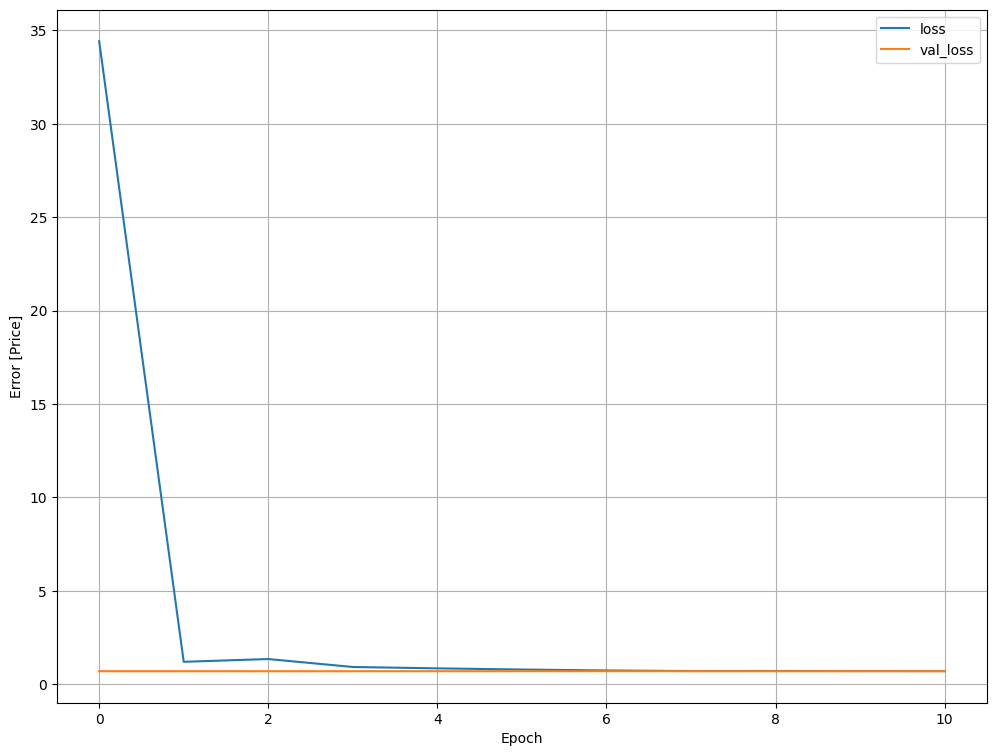

In [ ]:
from matplotlib import pyplot as plt

# Accessing the training loss values stored in the history object, which was returned by the model.fit() function during training.
plt.plot(history.history['loss'], label='loss') # ['loss'] comes from the fact that we specified in model.compile()
# The same, but plotting the validation loss values instead
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

The training loss starts higher, falls steeply after the first epoch, and then remains equal, with no improvement over time. The validation loss does not change, implying that the model is overfitting the training data. The same situation is observed for the AUC metric in the plot below.

The fluctuating training AUC shows some variation, reaching its highest point closely below 0.506 in the 5th epoch, but then fluctuating without showing a clear upward trend.  This suggests that deep learning model is not performing well, it might be learning the training data to some extent, but it's not translating into improved performance on unseen data.

There are many possible reasons for this: too complex model, small data set, features with a lack of predictive power on the target, hyperparameter tunning etc.

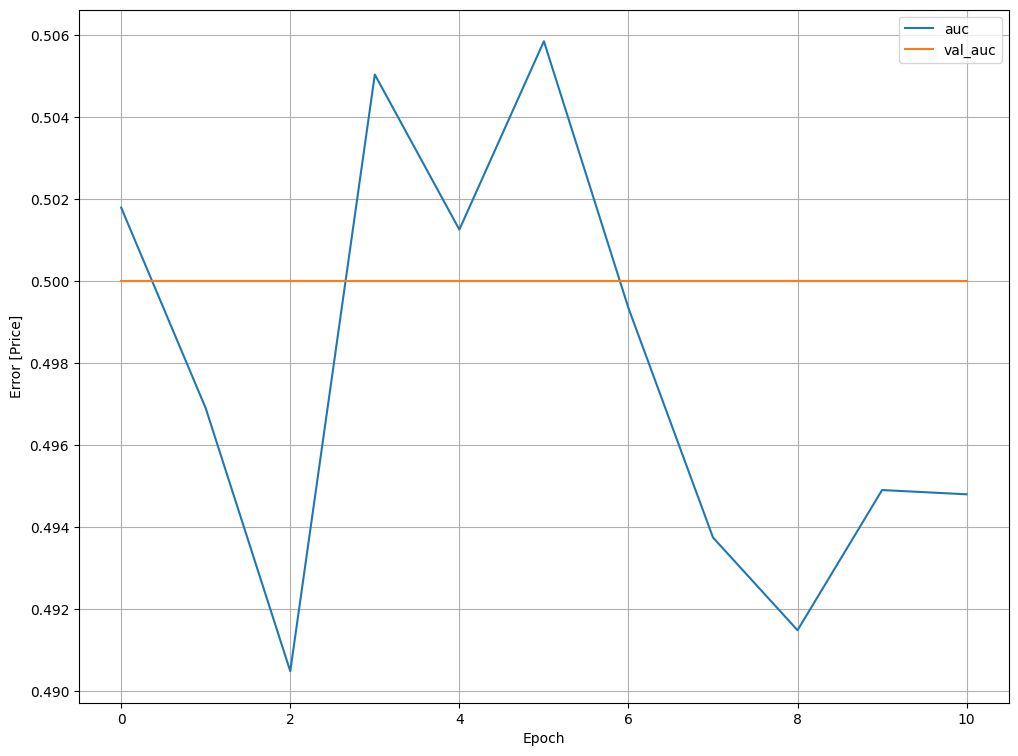

In [ ]:
# Accessing the training & validation AUC values stored in the history object during the model's training
plt.plot(history.history['AUC'], label='auc')
plt.plot(history.history['val_AUC'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

##Conclusion
The gradient boosting classifier provided the best AUC score on the validation set. It is a common machine learning practice to train multiple models on the same train/validation data set and provide a model that works best. To simulate a production environment, we have held the test set aside until now.

In the next cell, we are going to evaluate the performance of the gradient boosting classifier on the test set.

The last cell is showing a feature importance plot, which plots the importance of each feature in regard to the predictive performance of the model (the higher the value the more important the feature is for determining the value of the target variable).

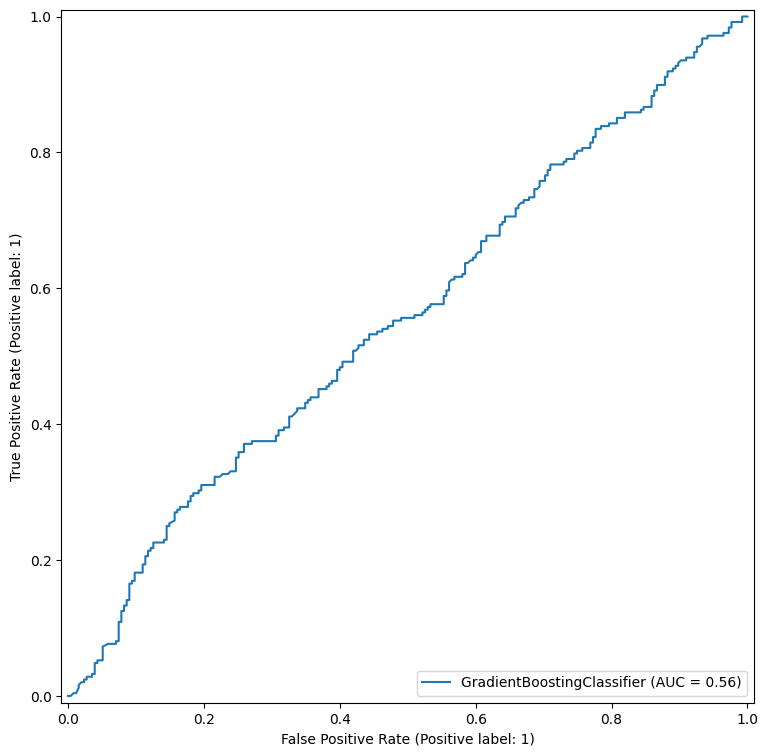

In [ ]:
# visualizes the performance of Gradient Boosting Classifier(gb)
RocCurveDisplay.from_estimator(gb, X_test, y_test)

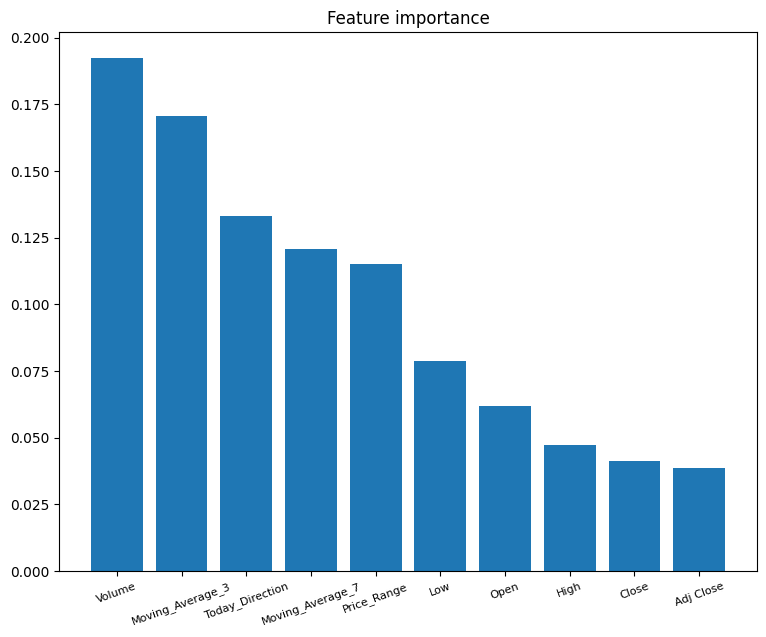

In [ ]:
import numpy as np
# Calculate feature importances
importances = gb.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [df_train[X_cols].columns[i] for i in indices]

_ = plt.figure(figsize=(9, 7))
plt.bar(names, importances[indices])
_ = plt.title("Feature importance")
_ = plt.xticks(rotation=20, fontsize = 8)

**Overall Insights**:

* **Trading volume is a key predictor**: The high importance of volume suggests that it's a primary driver for predicting price direction in this specific case. Analysing volume patterns might be crucial for understanding market sentiment and potential price movements.

* **Short-term trends remain relevant**: While not as dominant as volume, recent price trends captured by moving averages and the current day's direction are still valuable indicators for the model.

* **Fundamental price points have less influence**: Basic price points, while informative, are less influential compared to volume and short-term trends in this scenario.

**Considerations**:

* **Stock-specific behavior**: This feature importance ranking might be specific to the stock being analysed. Different stocks might exhibit varying relationships between volume, price trends, and price direction.

* **Model characteristics**: The Gradient Boosting model's inherent properties might influence the feature importance rankings. Other models might emphasize different features for prediction.

* **Data timeframe**: The period covered by the training data can also influence the feature importance. The relationship between volume and price direction might change over time.